In [3]:
import numpy as np 
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
import cmasher as cmr
from matplotlib import cm
from matplotlib.colors import Normalize

from matplotlib import rc
fontsize = 8
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import magnetics
import cloud
from importlib import reload
reload(magnetics)
from magnetics import Domain, Field
import cloud
reload(cloud)
from cloud import Cloud
from time import time
from joblib import Parallel, delayed
from units import kB
from units import h as hconst
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


# https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
def rgb_white2alpha(rgb, ensure_increasing=False):
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1) / alpha
    # Concatenate our alpha channel
    return np.concatenate((rgb, alpha), axis=1)

def cmap_white2alpha(cmap, ensure_increasing=True, 
                     register=False):
    # Fetch the cmap callable
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    # Get the colors out from the colormap LUT
    name=""
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(rgb, ensure_increasing=ensure_increasing)
    # Create a new Colormap object
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=name + "_alpha")
    if register:
        matplotlib.cm.register_cmap(name=name + "_alpha", cmap=cmap_alpha)
    return cmap_alpha

def plot_phasespace_color_mJ(C, ax, ti=None, coordx="z", coordy="vz", cmap="viridis", s=3, scale_velocity=False,
                             Nsample=None, scatter=True,imshow=False, alpha=None, color_density=True):
    base_colors = plt.get_cmap(cmap, int(2*C.J+1))
    colors = np.array([list(base_colors(mJi))[:3]
              for mJi in range(int(2*C.J +1))])
    for mJi, mJ in enumerate(C.mJ_states):
        color_list = [[0.9999, 0.9999, 0.9999], colors[mJi]]
        cmap = LinearSegmentedColormap.from_list("", color_list)
        cmap = cmap_white2alpha(cmap)
        obj = C.plot_phasespace_slice(coordx, coordy, ti=ti, ax=ax,
                            scale_velocity=scale_velocity,
                            scatter_kwargs={
                                "cmap":cmap, "s":s, "alpha":alpha
                            },
                            color_density=color_density,
                            Nsample=Nsample,
                            mJ_mask=mJ, 
                            scatter=scatter,
                            imshow=imshow,
                            contour=False);
    return obj


def calc_gJ(S, L, J):
    gs = 2.0023
    factor = (J*(J+1) - L*(L+1) + S*(S+1)) 
    factor /= (2*J*(J+1))
    return 1 + (gs - 1)*factor

In [5]:
RHH = 3.5
RAH = RHH/np.sqrt(3)
MHH = 7
MAH = 5
NHH = 2
NAH = 2
d=0.086
n = np.array([0, 0, 1.0])
r0 = 0.2*n
IHH = 1000
IAHtoHH = 800 / IHH
g = 0 #turn off gravity?
S = [0.25, 0.25, 0.25]
N = 1e4

In [6]:

Atoms = {}
Js = np.array([1,2,3,4,5,6,7,8])
fake_atoms = [f"J{i}" for i in Js]
MOT_wavelengths = np.array([671e-9]*len(Js))
masses = np.array([1.15e-25]*len(Js))
Trecoils = (6.6e-34/MOT_wavelengths)**2/(masses*1.38e-23) # (h/lmbda)^2 / (m kB)
#gJs = [calc_gJ(*term) for term in terms]
gJs = [2.00232]*len(Js)  # NIST ASD values
keys = ["mass", "Trecoil", "J", "gJ"]
for atom, *vals in zip(fake_atoms, masses, Trecoils, Js, gJs):
    Atoms[atom] = {k:v for k, v in zip(keys, vals)}

In [7]:
#https://tel.archives-ouvertes.fr/tel-01571420v2/document
# Appendix A

atoms = ["Li", "Cr", "Er", "Dy"]
# ground state (S, L, J)
terms = [(1/2, 0, 1/2), (3, 0, 3), (1, 5, 6), (2, 6, 8)]
MOT_wavelengths = np.array([671e-9, 425e-9, 583e-9, 626e-9]) * 1e2
masses = np.array([1.15e-26, 8.63e-26, 2.78e-25, 2.70e-25])
Trecoils = (hconst/MOT_wavelengths)**2/(masses*kB) # (h/lmbda)^2 / (m kB)
#vths = np.array([np.sqrt(kB*T/m) for T, m in zip(Trecoils, masses)])
Js = np.array([term[2] for term in terms])
gJs = np.array([2.00232, 2.00183, 1.16381, 1.24159])  # NIST ASD values


KB = 1.38e-23

keys = ["mass", "Trecoil", "J", "gJ"]
for atom, *vals in zip(atoms, masses, Trecoils, Js, gJs):
    Atoms[atom] = {k:v for k, v in zip(keys, vals)}

In [8]:
import magnetics
reload(magnetics)
from magnetics import Field

mop = Field()
mop.add_HH(r0=r0,
           n=n,
           ang=0,
           d=d,
           M=MHH,
           N=NHH,
           I=1,
           R=RHH,
           A=1/2*RHH - MHH/2*d
          )


mop.add_AH(r0=r0,
           n=n,
           ang=0,
           d=d,
           M=MAH,
           N=NAH,
           I=IAHtoHH,
           R=RAH,
           A=np.sqrt(3)/2*RAH - MAH/2*d
          )

mop.make_interpolation(meshspec=[[-0.75, 0.75,100]]*3)

In [9]:
 cmap = cmr.get_sub_cmap('cmr.chroma', 0.25, 0.90)

[  21.75737914   21.75737914 1515.30707812]
[13.00342079 13.00342079  8.11421525]
[0.59765566 0.59765566 0.00535483]
Plotting 3D field vectors...
Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...
Plotting 1D line cut of gradient...


<Figure size 640x480 with 0 Axes>

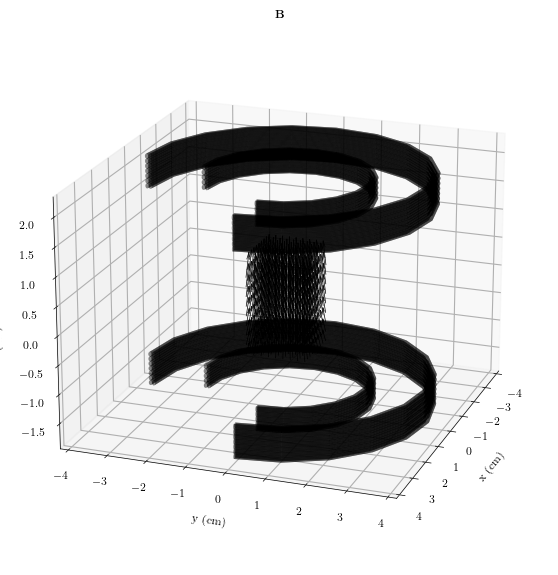

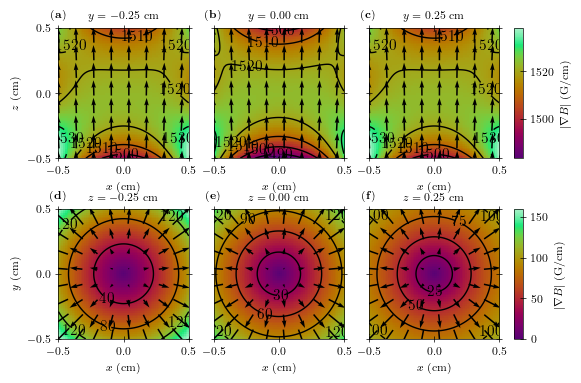

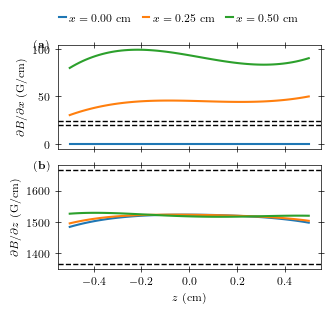

In [10]:
# import magnetics
reload(magnetics)
from magnetics import Field
from matplotlib.patches import Rectangle

mop_plot = Field()


mop_plot.add_HH(r0=r0,
           n=n,
           ang=0,
           d=d,
           M=MHH,
           N=NHH,
           I=IHH,
           R=RHH,
           A=1/2*RHH - MHH/2*d
          )


mop_plot.add_AH(r0=r0,
           n=n,
           ang=0,
           d=d,
           M=MAH,
           N=NAH,
           I=IHH*IAHtoHH,
           R=RAH,
           A=np.sqrt(3)/2*RAH - MAH/2*d
          )


mop_plot.make_interpolation(meshspec=[[-0.75, 0.75,100]]*3)


#Statistics
plot_domain = Domain(meshspec=[[-0.5, 0.5, 75]]*3)
stats_domain = Domain(meshspec=[[0, 0.25, 75],[0, 0.25, 75],[-0.5, 0.5, 75]] )
#to Gauss
grad_data = 1e4*np.array([1e12*interp(stats_domain.points) for interp in mop_plot.gradnormB_interp])
mean = np.mean(grad_data, axis=1)
std = np.std(grad_data, axis=1)
Gx, Gy, Gz = mean
dGx, dGy, dGz = std
print(mean)
print(std)
print(std/mean)

#3D plot
mop_plot.plot_3d(azim=20, elev=20, skip=12)
#plt.savefig("figures/mop_field_3D.pdf")
#plt.savefig("figures/mop_field_3D.png", dpi=600)

# 2D plots
fig2d, axs2d = mop_plot.plot_slices(
                    planes={"y":[-0.25, 0.0, 0.25], 
                            "z":[-0.25, 0.0, 0.25]}, 
                    figsize=(6, 4.3),
                    unit="G_per_cm", 
                    domain=plot_domain, contours=4, cmap=cmap)
axs2d[0,0].set_yticks([-0.5, 0, 0.5])
axs2d[1,0].set_yticks([-0.5, 0, 0.5])
lettering(axs2d[0,0], -0.0, 1.1, 0)
lettering(axs2d[0,1], -0.0, 1.1, 1)
lettering(axs2d[0,2], -0.0, 1.1, 2)
lettering(axs2d[1,0], -0.0, 1.1, 3)
lettering(axs2d[1,1], -0.0, 1.1, 4)
lettering(axs2d[1,2], -0.0, 1.1, 5)
#plt.tight_layout()
plt.savefig("figures/mop_gradnorm_slices.pdf")




#plt.savefig("figures/mop_gradnorm_slices.png", dpi=600)

# 1D plots
fig, axs = mop_plot.plot_linecuts(
        components="xz",
        lines=[[0.0, 0.0, "var"],[0.25, 0.0, "var"], [0.5, 0.0, "var"]],
        grad_norm=True,
        domain=plot_domain,
        gauss=True,
        figsize=(3.375, 3.), legend=False)

#axs[1].axhline(mean[2], c="k", zorder=1)
#axs[1].axhline(mean[2]+std[2], c="k", zorder=10)
#axs[1].axhline(mean[2]-std[2], c="k", zorder=10)
axs[1].axhline(mean[2]+mean[2]*0.1, ls="--", c="k", zorder=10, lw=1)
axs[1].axhline(mean[2]-mean[2]*0.1, ls="--", c="k", zorder=10, lw=1)

#axs[0].axhline(mean[1], c="k", zorder=10)
#axs[0].axhline(mean[1]+std[1], c="k", zorder=10)
#axs[0].axhline(mean[1]-std[1], c="k", zorder=10)
axs[0].axhline(mean[1]+mean[1]*0.1, ls="--", c="k", zorder=10, lw=1)
axs[0].axhline(mean[1]-mean[1]*0.1, ls="--", c="k", zorder=10, lw=1)
plt.tight_layout()
axs[0].legend([r"$x=0.00~{\rm cm}$", r"$x=0.25~{\rm cm}$", r"$x=0.50~{\rm cm}$"],
             frameon=False, handlelength=0.6, handletextpad=0.3, 
             labelspacing=0.2, loc="upper center", bbox_to_anchor=(0.46,1.4), ncol=3, columnspacing=1)
#axs[1].set_yticks([850, 900, 950, 1000])
lettering(axs[0], -0.06, 1, 0)
lettering(axs[1], -0.06, 1, 1)
plt.subplots_adjust(top=0.9)

plt.savefig("figures/mop_gradnorm_lines.pdf")
#plt.savefig("figures/mop_gradnorm_lines.png", dpi=600)


Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...


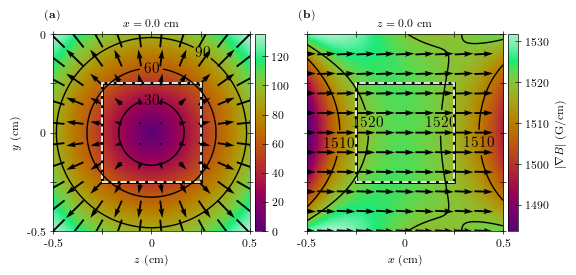

In [11]:
plot_domain = Domain(meshspec=[[-0.5,0.5, 101]]*3)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharey=True)


mop_plot.plot_slice(ax=axs[0], 
                    plane=("z", 0.0),
                    domain=plot_domain,
                    transpose=False,
                    unit="G_per_cm", 
                    image=True,
                    cmap=cmap,
                    contours=[30, 60, 90], 
                    label_contours=True,
                    contour_label_positions=[(0, 0.2),(0,0.3),(0.25, 0.4)],
                    arrows=True,
                    skip_arrows=11)

mop_plot.plot_slice(ax=axs[1], 
                    plane=("x", 0.0),
                    domain=plot_domain,
                    transpose=True,
                    unit="G_per_cm", 
                    image=True,
                    cmap=cmap,
                    contours=[1510, 1520], 
                    label_contours=True,
                    contour_label_positions=[(0.2, 0.05),(0.4, -0.05),(-0.2, 0.05),(-0.4, -0.05)],
                    arrows=True,
                    skip_arrows=10)

for axi, ax in enumerate(axs):
    lettering(axs[axi], -0.0, 1.1, axi)
    ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, color="k", fill=None, alpha=1, lw=2, ls="-"))
    ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, color="w", fill=None, alpha=1, lw=1.25, ls="--"))
    ax.set_xticks([-0.5, -0.25, 0, 0.25,  0.5])
    ax.set_yticks([-0.5, -0.25, 0, 0.25,  0.5])
    ax.set_xticklabels([-0.5, "", 0, "", 0.5])
    ax.set_yticklabels([-0.5, "", 0, "", 0])

axs[0].get_images()[-1].colorbar.set_label("")
plt.subplots_adjust(wspace=0.2)
axs[1].set_ylabel("")
axs[0].set_title("$x=0.0$ cm")
axs[1].set_title("$z=0.0$ cm")
axs[1].set_xlabel("$x$ (cm)")
axs[0].set_xlabel("$z$ (cm)")
#plt.tight_layout()
plt.savefig("figures/mop_gradnorm_slices_V3.pdf", bbox_inches="tight")

Plotting 2D contour slice of gradient...
Plotting 2D contour slice of gradient...


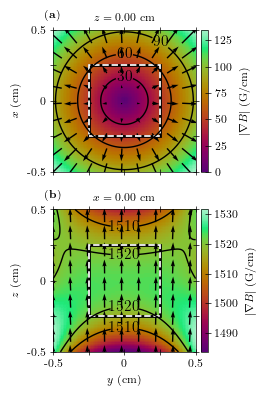

In [12]:
plot_domain = Domain(meshspec=[[-0.5,0.5, 101]]*3)

fig, axs = plt.subplots(2, 1, figsize=(2.7, 4), sharex=True)


mop_plot.plot_slice(ax=axs[0], 
                    plane=("z", 0.0),
                    domain=plot_domain,
                    transpose=True,
                    unit="G_per_cm", 
                    image=True,
                    cmap=cmap,
                    contours=[30, 60, 90], 
                    label_contours=True,
                    contour_label_positions=[(0, 0.2),(0,0.3),(0.25, 0.4)],
                    arrows=True,
                    skip_arrows=12)

mop_plot.plot_slice(ax=axs[1], 
                    plane=("x", 0.0),
                    domain=plot_domain,
                    transpose=False,
                    unit="G_per_cm", 
                    image=True,
                    cmap=cmap,
                    contours=[1510, 1520], 
                    label_contours=True,
                    contour_label_positions=[(0, 0.2),(0,0.4),(0, -0.2),(0, -0.4)],
                    arrows=True,
                    skip_arrows=12)

for axi, ax in enumerate(axs):
    lettering(axs[axi], -0.0, 1.1, axi)
    ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, color="k", fill=None, alpha=1, lw=2, ls="-"))
    ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, color="w", fill=None, alpha=1, lw=1.25, ls="--"))
    ax.set_xticks([-0.5, -0.25, 0, 0.25,  0.5])
    ax.set_yticks([-0.5, -0.25, 0, 0.25,  0.5])
    ax.set_xticklabels([-0.5, "", 0, "", 0.5])
    ax.set_yticklabels([-0.5, "", 0, "", 0.5])
axs[0].set_xlabel("")
plt.tight_layout()
plt.savefig("figures/mop_gradnorm_slices_V2.pdf")
plt.savefig("figures/mop_gradnorm_slices_V2.png", dpi=1000)

In [13]:
reload(cloud)
from cloud import Cloud
def cycle_pulses(t0, tau, expand_tof=False, scale=1.0):
    if expand_tof:
        expansion = {
            "field": "expand_tof",
            "mJ_rule": None,
            "mJ_coord": None,
            "tau": 0,
            "t0": t0
        }
    else:
        expansion = {
            "field": None,
            "mJ_rule": None,
            "mJ_coord": None,
            "tau": 0,
            "t0": t0
        }
        
    return [{
        "field": mop,
       "t0": 0,
       "tau": tau,
       "shape": "sin",
       "scale": IHH*scale,
       "mJ_coord": "z",
       "mJ_rule": "equal_length",
       "name": "kick"
    },
        
        expansion,
           
        {
        "field": mop,
        "t0": 0,
        "tau": tau,
        "shape": "sin",
        "scale": -IHH*scale,
        "mJ_coord": None,
        "mJ_rule": "equal_length",
        "name":"unkick" },
         ]


def get_sim(atom, t0, tau, spatial_distribution, recoil_factor, dt=1.0, expand_tof=False, scale=1.0):
    J = Atoms[atom]["J"]
    gJ = Atoms[atom]["gJ"]
    mass = Atoms[atom]["mass"]
    Trec = Atoms[atom]["Trecoil"]
    C = Cloud(
             g=g,
             S=S, 
             N=N,
             T=recoil_factor*Trec,  
             J=J,
             gJ=gJ,
             mass=mass,
             )
    C.initialize_state(spatial_distribution=spatial_distribution)
    C.initialize_run(cycle_pulses(t0, tau, expand_tof, scale=scale), dt=dt)
    C.run()
    return C

def get_ratio(atom, t0, tau, spatial_distribution, recoil_factor, dt=1.0):
    C = get_sim(atom, t0, tau, spatial_distribution, recoil_factor, dt)
    ratio = np.std(C.states[0,:,:3], axis=0) / np.std(C.states[-1,:,:3], axis=0) 
    return ratio

In [21]:
n_jobs=-1
tau = 300
dt = 1
recoil_factors = np.linspace(25, 100, 1)
spatial_distributions = ["flat", "gauss"]
t0s_list = [np.linspace(0, 6000, 101), np.linspace(0, 12000, 101)]

atom_list  = atoms
Js_list = [Atoms[atom]["J"] for atom in atom_list]
args_list = []
for disti, dist in enumerate(spatial_distributions):
    t0s = t0s_list[disti]
    for atomi, atom in enumerate(atom_list):
        for t0i, t0 in enumerate(t0s):
            for reci, recoil_factor in enumerate(recoil_factors):
                args = [atom, t0, tau, dist, recoil_factor, dt]
                args_list.append(args)
print(len(args_list))
ratios = np.array(Parallel(n_jobs=n_jobs)(delayed(get_ratio)(*args) for args in args_list)) 
ratios = ratios.reshape((len(spatial_distributions), len(atom_list), len(t0s), len(recoil_factors), 3));   

808


In [22]:
RR = np.array([Atoms[atom]["gJ"] * 9.277e-24 / Atoms[atom]["mass"] for atom in atoms])
GG = Gz / 1e2
TT = tau*1e-6
KB = 1.38e-23
Dv = 2*TT*GG*RR / np.pi
vths2 = np.array([np.sqrt(KB * recoil_factor*Atoms[atom]["Trecoil"]/ Atoms[atom]["mass"]) for atom in atoms])
gg = Dv / vths2



Dv2 = 2 * TT*(GG+2*dGz)/1e2 * RR / np.pi
dv = Dv2 - (2 * TT*(GG-2*dGz)/1e2 * RR / np.pi)




def Ratio_func(ts, J, g, vth, s):
    return 1/np.sqrt( 1 - 4*ts*g*vth/s * J*(J+1)/(2*J+1) 
                            + (ts*vth/s)**2 * (3+g*g*J*(J+1))) 

(-0.6000000000000001, 20.0)

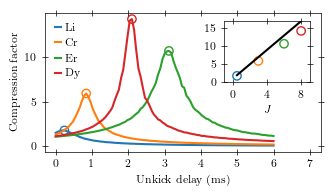

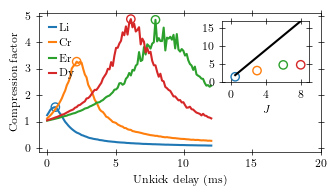

In [28]:
#ratios = np.array([np.std(C.states[-1,:,:3]/np.std(C.states[0,:,:3], axis=0), axis=0) for C in sims])
inds = np.argmax(ratios[:,:,:,:,2], axis=2)
t0_opts = np.zeros((len(spatial_distributions), len(Js), len(recoil_factors)))
ratio_opts = np.zeros((len(spatial_distributions), len(Js), len(recoil_factors)))


for reci, recoil_factor in enumerate(recoil_factors):
    for disti, dist in enumerate(spatial_distributions[:]):
        fig, ax = plt.subplots(1, 1, figsize=(3.375, 2))
        t0s = t0s_list[disti]
        for atomi, name in enumerate(atom_list):
            rs = ratios[disti, atomi, :, reci, :]
            color = f"C{atomi}"
            plt.plot(t0s/1e3, rs[:, 2], c=color, ls="-", label=name, zorder=atomi)
            ind = inds[disti, atomi, reci]
            t0_opts[disti, atomi, reci] = t0s[ind]
            ratio_opts[disti, atomi, reci] = rs[ind, 2]
            plt.scatter(t0s[ind]/1e3, rs[ind, 2], fc="none", ec=color)
            
            
            #plt.plot(t0s/1e3, Ratio_func(t0s/1e4, J=Js[atomi],
            #                             g=gg[atomi], vth=vths2[atomi], s=S[0]), c="k")
        
        ax.legend(frameon=False, loc="upper left", handlelength=0.6, handletextpad=0.3,)
        ax.set_ylabel("Compression factor")
        ax.set_xlabel("Unkick delay (ms)")
        #ax.set_xscale("log")
        for atomi, name in enumerate(atom_list):
            #if disti == 0:
                #.axhline(2*Atoms[name]["J"]+1, color=f"C{atomi}", lw=0)
            plt.tight_layout()
        inax = ax.inset_axes([0.65, 0.5, 0.31, 0.44])            
        inax.scatter(Js_list, ratio_opts[disti, :, reci].T, marker="o", fc="none", ec=["C0","C1","C2","C3"])
        inax.set_xticks([0,4,8])
        inax.set_yticks([0,5,10,15])
        inax.set_xlim(-1, 9)
        inax.set_ylim(0, 17)
        inax.plot(Js, (2*Js+1), c="k")
        inax.set_xlabel("$J$")
        \
        #fname = f"figures/compression_factor_vs_unkick_delay_{dist}_{rule}_{int(tau)}us-pulse_temperature-corrected.pdf"
        #plt.savefig(fname)
        ax.set_xlim(right=7.3)
        #plt.savefig(f"figures/compression_factor_vs_unkick_delay_flat_{int(tau)}us-pulse.pdf", dpi=1000)
    
ax.set_xlim(right=20)


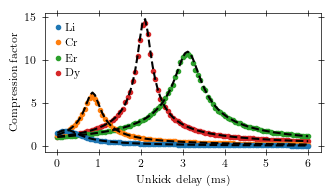

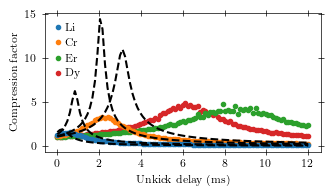

In [24]:
for reci, recoil_factor in enumerate(recoil_factors):
    for disti, dist in enumerate(spatial_distributions[:]):
        fig, ax = plt.subplots(1, 1, figsize=(3.375, 2))
        t0s = t0s_list[disti]
        for atomi, name in enumerate(atom_list):
            rs = ratios[disti, atomi, :, reci, :]
            color = f"C{atomi}"
            plt.plot(t0s/1e3, rs[:, 2], c=color, ls="none", label=name, zorder=4-atomi, marker=".",)
            #ind = inds[disti, atomi, reci]
            #t0_opts[disti, atomi, reci] = t0s[ind]
            #ratio_opts[disti, atomi, reci] = rs[ind, 2]
            #plt.scatter(t0s[ind]/1e3, rs[ind, 2], fc="none", ec=color)           
            plt.plot(t0s/1e3, Ratio_func((t0s+300)/1e6, J=Js[atomi],
                                         g=gg[atomi], vth=vths2[atomi], s=S[0]/1e2),
                     c="k", ls="--", zorder=atomi+10)
        
        ax.legend(frameon=False, loc="upper left", handlelength=0.6, handletextpad=0.3,)
        ax.set_ylabel("Compression factor")
        ax.set_xlabel("Unkick delay (ms)")
        plt.tight_layout()
        plt.savefig(f"figures/compression_factor_model_and_sim_{dist}.pdf", dpi=1000)


In [25]:
ratio_opts, t0_opts

(array([[[ 1.79843863],
         [ 5.94041042],
         [10.70898307],
         [14.27445564]],
 
        [[ 1.5436844 ],
         [ 3.26243444],
         [ 4.84327068],
         [ 4.87108412]]]),
 array([[[ 240.],
         [ 840.],
         [3120.],
         [2100.]],
 
        [[ 600.],
         [2160.],
         [7920.],
         [6120.]]]))

In [207]:
gg

array([10.89172986,  6.89694844,  5.50036481,  6.30076664])

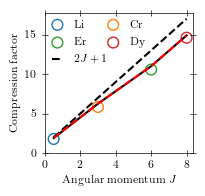

In [312]:
fig, ax = plt.subplots(1,1, figsize=(2.1, 2))
factors = ratio_opts[0].T[0]
colors = ["C0","C1","C2","C3"]
for color, J, factor, label in zip(colors, Js, factors, atoms):
    ax.scatter(J, factor, s=60, marker="o", fc="none", ec=color, label=label)
    #plt.scatter(Js, 1/ratio_opts[1].T[0], s=75, c=["C0","C1","C2","C3"])



ax.plot(Js, (2*Js+1), c="k", label="$2J+1$", ls="--")

ax.plot(Js, (2 * Js + 1 ) / np.sqrt(1 + 12/gg**2), 
        c="k", label=r"$\frac{2J+1}{\sqrt{1+ 12 (v_{\rm th}/{\Delta v})^2}}$")

ax.plot(Js, (2 * Js + 1 ) * np.sqrt((3+Js*(Js+1)*gg*gg) / (3 + Js*(Js+1)*(12+gg*gg))), 
        c="r", ls="--",label=r"$\frac{2J+1}{\sqrt{1+ 12 (v_{\rm th}/{\Delta v})^2}}$")



#ax.plot(Js, (2*Js + 1 ) / np.sqrt(1 + (12*vths2**2 * (1/Dv  + TT *(2*Js+1)/(2*S[2]*1e-2))**2)), 
#        c="k", ls="--", label=r"$\frac{2J+1}{v_{\rm th}/{\Delta v}+1}$")



#ax.plot(Js, 
#        1 / np.sqrt(1 + (np.array(vths2)**2 * (t0s+2*TT)**2 - (Dv*(2*Js+1)*t0s)**2 )/(S[2]*1e-2)**2), 
#        
#        c="r", label="$2J+1...$")


ax.set_ylim(bottom=0)
h, l = ax.get_legend_handles_labels()
inds = [0, 2, 4, 1, 3]
h = [h[ind] for ind in inds]
l = [l[ind] for ind in inds]
ax.legend(h, l, ncols=2, handlelength=1, columnspacing=0, labelspacing=0.7, 
          handletextpad=1, 
          frameon=False, loc="upper left", bbox_to_anchor=(-0.02, 1.02))
ax.set_xticks((0, 2, 4, 6, 8))
ax.set_xlabel("Angular momentum $J$")
ax.set_ylabel("Compression factor")
plt.tight_layout()
#plt.savefig("figures/peak_compression_vs_species_temperature-corrected-new-field.pdf", bbox_inches="tight")
#plt.savefig("figures/peak_compression_vs_species_temperature-corrected-new-field.png", dpi=1000, bbox_inches="tight")

In [314]:
Cs = []
dt = 1
spatial_distribution = spatial_distributions[0]
recoil_factor = recoil_factors[0]
atom = "Dy"
atomi = 3

def get_sim_S(atom, t0, tau, spatial_distribution, recoil_factor, S=S, dt=1.0, expand_tof=False, scale=1.0):
    J = Atoms[atom]["J"]
    gJ = Atoms[atom]["gJ"]
    mass = Atoms[atom]["mass"]
    Trec = Atoms[atom]["Trecoil"]
    print(spatial_distribution)

    C = Cloud(
             g=g,
             S=S, 
             N=N,
             T=recoil_factor*Trec,  
             J=J,
             gJ=gJ,
             mass=mass,
             )
    C.initialize_state(spatial_distribution=spatial_distribution)
    print(S, np.std(C.state, axis=0))

    C.initialize_run(cycle_pulses(t0, tau, expand_tof, scale=scale), dt=dt)
    C.run()
    return C

#for spatial_distribution, SS in zip(["flat", "gauss"], [S, S/np.sqrt(12)/0.5]):
    
for atom, t0 in zip(atom_list, t0_opts[0,:,0]): 
    C = get_sim(atom, t0, tau, spatial_distribution, recoil_factor,
                dt=dt, expand_tof=False, scale=1)
    #print(get_ratio(atom, t0, tau, spatial_distribution, recoil_factor))
    Cs.append(C)

85.86885297738611
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408
3.9202875636019408


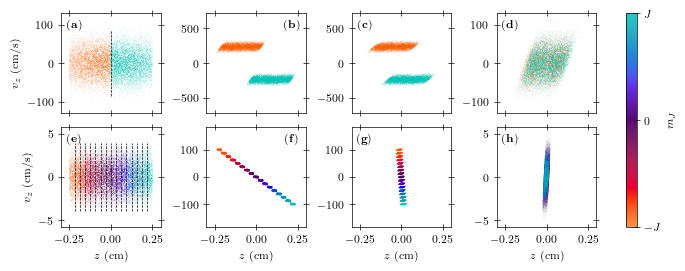

In [315]:
fig, axs = plt.subplots(2,4, figsize=(3.375*2, 2.6), sharex=True, constrained_layout=True)
coordx="z"
coordy="vz"
scale_velocity=False
cmap = "cmr.guppy"
for Ci, C in enumerate([Cs[0], Cs[-1]]):
    for axi, ti in enumerate([1, int(tau/dt), int(tau/dt)+1,-1][::-1]):
        plot_phasespace_color_mJ(C, axs[Ci, 3-axi], ti=ti, coordx=coordx, coordy=coordy, 
                                scale_velocity=scale_velocity,
                                cmap=cmap,
                                s=0.2)
    if C.J == 1/2:
        vals = [0.0]
    else:
        vals = np.linspace(-C.S0[2], C.S0[2], int(2*C.J+1))[1:-1]
    for val in vals:
        extent = 2*np.sqrt(C.T0[2] * kB / C.mass) * 1e6
        print(extent)
        axs[Ci,0].plot([val, val], [-extent, extent], c="k", ls="--", lw=0.5)


axs[0,0].set_ylabel("$v_z$ (cm/s)")
axs[1,0].set_ylabel("$v_z$ (cm/s)")
axs[-1,0].set_xlabel("$z$ (cm)")
axs[-1,1].set_xlabel("$z$ (cm)")
axs[-1,2].set_xlabel("$z$ (cm)")
axs[-1,3].set_xlabel("$z$ (cm)")
axs[-1,-1].set_xlim(-0.3, 0.3)
axs[-1,-1].set_xticks([-0.25, 0, 0.25])

"""
axs[0,0].set_ylim(-2.3*31, 2.3*31)
axs[0,1].set_ylim(-60, 60)
axs[0,2].set_ylim(-60, 60)
axs[0,-1].set_ylim(-2.3*31, 2.3*31)


axs[-1,0].set_ylim(-0.15*31, 0.2*31)
axs[-1,1].set_ylim(-22, 22)
axs[-1,2].set_ylim(-22, 22)
axs[-1,-1].set_ylim(-0.15*31, 0.2*31)
axs[-1,-1].set_yticks(31*np.array([-0.1, 0.0, 0.1, 0.2]))
"""
lettering(axs[0, 0], 0.14, 0.88, 0)
lettering(axs[0, 1], 1-0.14, 0.88, 1)
lettering(axs[0, 2], 0.14, 0.88, 2)
lettering(axs[0, 3], 0.14, 0.88, 3)

lettering(axs[1, 0], 0.14, 0.88, 4)
lettering(axs[1, 1], 1-0.14, 0.88, 5)
lettering(axs[1, 2], 0.14, 0.88, 6)
lettering(axs[1, 3], 0.14, 0.88, 7)



cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(-1,1), cmap=cmap), 
                    ax=axs, location='right', ticks=[-1,0,1])
cbar.ax.set_yticklabels(["$-J$", "$0$", "$J$"]) 
cbar.ax.set_ylabel(r"$m_J$")
plt.savefig("figures/phase_space_sample.pdf", dpi=1000)
#plt.savefig("figures/phase_space_sample_temperature-corrected-new-field.pdf", dpi=600)

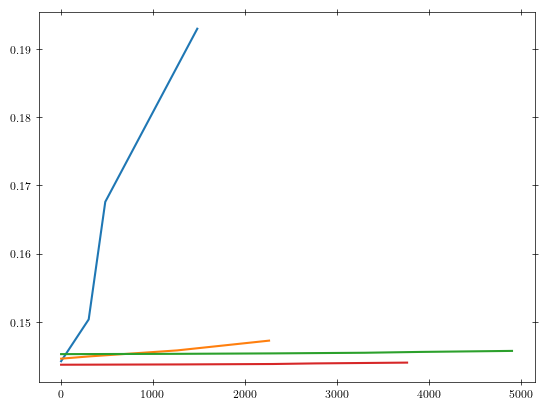

In [94]:
for C in Cs:
    plt.plot(C.ts, np.mean(np.std(C.states[:, :, :3], axis=1), axis=1))
#plt.axhline(2*S[0]/np.sqrt(12))

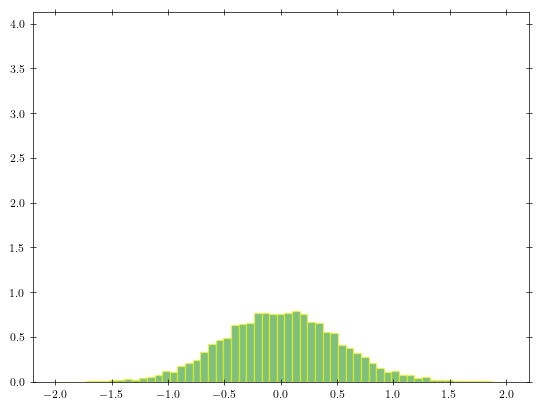

In [923]:

import matplotlib.animation as animation
from IPython.display import HTML

ind = 2





fig, ax = plt.subplots()
data = C.states[0, :, ind]
ts = C.ts
HIST_BINS = np.linspace(-2, 2 , 60)
hist, bins, bar_container = ax.hist(data, HIST_BINS, lw=1, density=True,
                              ec="yellow", fc="green", alpha=0.5)
line, _ = plt.plot()
ax.set_ylim(top=np.max(hist)*2)  # set safe limit to ensure that all data is visible.


def prepare_animation(bar_container):

    def animate(frame_number):
       
        #data = np.random.randn(1000)
        data = C.states[frame_number+1, :, ind]
        n, _ = np.histogram(data, HIST_BINS, density=True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate

anim = animation.FuncAnimation(fig, prepare_animation(bar_container), len(ts)-1,
                              repeat=False, blit=True)
HTML(anim.to_html5_video())


IndexError: index 301 is out of bounds for axis 0 with size 4

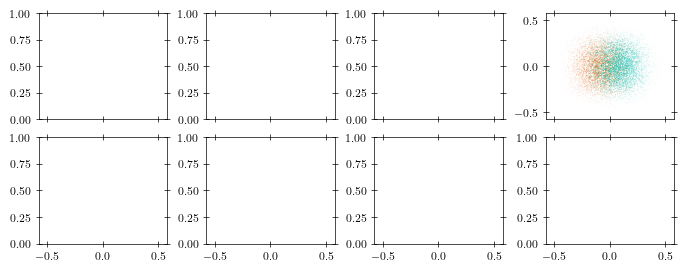

In [875]:
atom = "Dy"
J = Atoms[atom]["J"]
gJ = Atoms[atom]["gJ"]
mass = Atoms[atom]["mass"]
T = recoil_factor*Atoms[atom]["Trecoil"]

spatial_distribution = spatial_distributions[0]
recoil_factor = recoil_factors[0]
t0 = t0_opts[0, atoms.index(atom), 0]


C0 = Cloud(g=g, S=S/(2*J+1), N=N, T=T, J=J, gJ=gJ, mass=mass)
C0.initialize_state(spatial_distribution=spatial_distribution)
pulses = cycle_pulses(t0, tau, scale=0)
C0.initialize_run(pulses, dt=1.0)
C0.run()

In [876]:
recoil_factor

25.0

(13.890976862898153, 12.600664748263826)

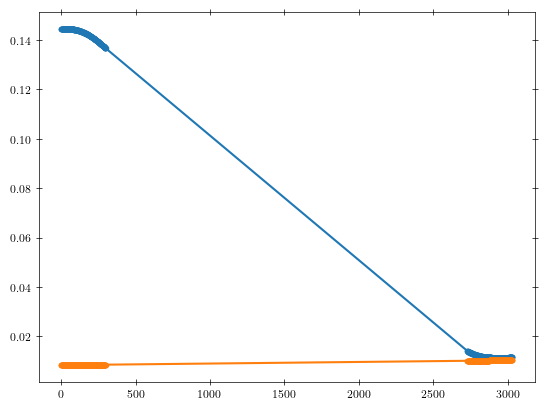

In [877]:
plt.plot(Cs[-1].ts[:-1], np.std(Cs[-1].states[:,:, 2], axis=1)[1:], marker=".")
plt.plot(C0.ts[:-1], np.std(C0.states[:,:, 2], axis=1)[1:], marker=".")
np.std(Cs[-1].states[:,:, 2], axis=1)[0] / np.std(C0.states[:,:, 2], axis=1)[-1], np.std(Cs[-1].states[:,:, 2], axis=1)[0] / np.std(Cs[-1].states[:,:, 2], axis=1)[-1]

#plt.plot(C0.ts[:], np.sqrt((Cs[-1].S0[2]/(2*J+1)*2/np.sqrt(12))**2 + Atoms[atom]["vth"]**2*C0.ts**2))

In [10]:
reload(cloud)
recoil_factor=1e-12
#https://tel.archives-ouvertes.fr/tel-01571420v2/document
# Appendix A
Js = np.array([1,2,3,4,5,6,7,8])

fake_atoms = [f"J{i}" for i in Js]


MOT_wavelengths = np.array([671e-9]*len(Js))
masses = np.array([1.15e-26]*len(Js))
Trecoils = (6.6e-34/MOT_wavelengths)**2/(masses*1.38e-23) # (h/lmbda)^2 / (m kB)
vths = np.array([np.sqrt(kB*T/m) for T, m in zip(Trecoils*recoil_factor, masses)])
#gJs = [calc_gJ(*term) for term in terms]
gJs = [2.00232]*len(Js)  # NIST ASD values
keys = ["mass", "Trecoil", "vth", "J", "gJ"]
for atom, *vals in zip(fake_atoms, masses, Trecoils, vths, Js, gJs):
    Atoms[atom] = {k:v for k, v in zip(keys, vals)}

from cloud import Cloud
def _cycle_pulses(t0, tau, rule, ukick_factor):
    return [
            {"field": None,
             "mJ_rule": "optical_pumping",
             "mJ_coord": None,
            "tau": 0,
            "t0": 0},
        
            {"field": mop,
           "t0": 0,
           "tau": tau,
           "shape": "sin",
           "scale": 1000,
           "mJ_coord": "z",
           "mJ_rule": rule,
           "name": "kick"},
            
            {"field": None,
            "mJ_rule": None,
            "mJ_coord": None,
            "tau": 0,
            "t0": t0/4},
           
           {"field": None,
            "mJ_rule": None,
            "mJ_coord": None,
            "tau": 0,
           "t0": 3*t0/4},
           
           {"field": mop,
           "t0": 0,
           "tau": tau,
           "shape": "sin",
           "scale": -1000*ukick_factor,
           "mJ_coord": None,
           "mJ_rule": rule,
           "name":"unkick" },
        
        {"field": None,
             "mJ_rule": "optical_pumping",
             "mJ_coord": None,
            "tau": 0,
            "t0": 0},
         ]


def _get_sim(t0, tau, rule, J, gJ, mass, T, spatial_distribution, ukick_factor):
    tic = time()
    C = Cloud(
             g=g,
             S=S, 
             N=N,
             T=T,  
             J=J,
             gJ=gJ,
             mass=mass)
    C.initialize_state(spatial_distribution=spatial_distribution)
    C.initialize_run(_cycle_pulses(t0, tau, rule, unkick_factor), dt=1.0)
    C.run()
    return C


n_jobs=-1
t0s = np.linspace(0, 50, 10)
taus = np.linspace(300, 1000, 1)
spatial_distributions = ["flat", "gauss"]
unkick_factor=1

args_list = []
for disti, dist in enumerate(spatial_distributions):
    if dist == "flat":
        rule = "equal_length"
    elif dist == "gauss":
        rule = "equal_length"
    for atomi, atom in enumerate(fake_atoms):
        J = Atoms[atom]["J"]
        gJ = Atoms[atom]["gJ"]
        mass = Atoms[atom]["mass"]
        T = recoil_factor*Atoms[atom]["Trecoil"]
        for t0i, t0 in enumerate(t0s):
            for taui, tau in enumerate(taus):
                args = [t0, tau, rule, J, gJ, mass, T, dist, unkick_factor]
                args_list.append(args)
print(len(args_list))
sims = np.array(Parallel(n_jobs=n_jobs)(delayed(_get_sim)(*args) for args in args_list)) 


unkick_factor = 1.0

160


/tmp/ipykernel_799575/3349982530.py:3: RuntimeWarning: divide by zero encountered in divide
  inds = np.argmax(1/ratios[:,:,:,:,2], axis=2)
/tmp/ipykernel_799575/3349982530.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(t0s/1e3, 1/rs[:, 2], c=color, ls="-", label=name, zorder=atomi)
/tmp/ipykernel_799575/3349982530.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  plt.scatter(t0s[ind]/1e3, 1/ratios[disti, atomi, ind, taui, 2], fc="none", ec=color)
/tmp/ipykernel_799575/3349982530.py:25: RuntimeWarning: divide by zero encountered in divide
  inax.scatter(Js, 1/ratio_opts[disti].T[0], marker="o", fc="none", ec=["C0","C1","C2","C3"])


figures/compression_factor_vs_unkick_delay_flat_equal_length_300us-pulse.pdf
figures/compression_factor_vs_unkick_delay_gauss_equal_length_300us-pulse.pdf


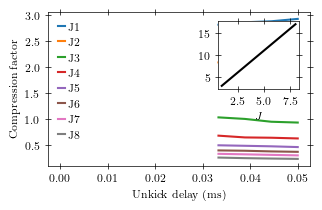

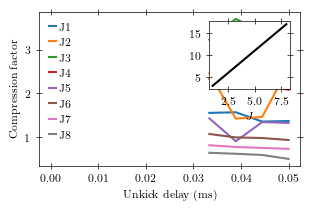

In [11]:
ratios = np.array([np.std(C.states[-1,:,:3]/np.std(C.states[0,:,:3], axis=0), axis=0) for C in sims])
ratios = ratios.reshape((len(spatial_distributions), len(Js), len(t0s), len(taus), 3));   
inds = np.argmax(1/ratios[:,:,:,:,2], axis=2)
t0_opts = np.zeros((len(spatial_distributions), len(Js), len(taus)))
ratio_opts = np.zeros((len(spatial_distributions), len(Js), len(taus)))


for taui, tau in enumerate(taus):
    for disti, dist in enumerate(spatial_distributions[:]):
        fig, ax = plt.subplots(1, 1, figsize=(3.375, 2))
        for atomi, name in enumerate(fake_atoms):
            rs = ratios[disti, atomi,:, taui, :]
            color = f"C{atomi}"
            plt.plot(t0s/1e3, 1/rs[:, 2], c=color, ls="-", label=name, zorder=atomi)
            ind = inds[disti, atomi, taui]
            t0_opts[disti, atomi, taui] = t0s[ind]
            ratio_opts[disti, atomi, taui] = ratios[disti, atomi, ind, taui, 2]

            plt.scatter(t0s[ind]/1e3, 1/ratios[disti, atomi, ind, taui, 2], fc="none", ec=color)
        
        ax.legend(frameon=False, loc="upper left", handlelength=0.6, handletextpad=0.3,)
        ax.set_ylabel("Compression factor")
        ax.set_xlabel("Unkick delay (ms)")
        inax = ax.inset_axes([0.65, 0.5, 0.31, 0.44])            
        inax.scatter(Js, 1/ratio_opts[disti].T[0], marker="o", fc="none", ec=["C0","C1","C2","C3"])
        inax.plot(Js, 2*Js+1, c="k")
        inax.set_xlabel("$J$")
        fname = f"figures/compression_factor_vs_unkick_delay_{dist}_{rule}_{int(tau)}us-pulse.pdf"
        print(fname)
        #plt.savefig(fname)
        #plt.savefig(f"figures/compression_factor_vs_unkick_delay_{spatial_distribution}_{rule}_{int(tau)}us-pulse.png", dpi=600)
    


In [361]:
spatial_distribution = "flat"
Cs = []
for atomi, atom in enumerate(fake_atoms):
    print(atom)
    J = Atoms[atom]["J"]
    gJ = Atoms[atom]["gJ"]
    mass = Atoms[atom]["mass"]
    T = recoil_factor*Atoms[atom]["Trecoil"]
    t0 = t0_opts[spatial_distributions.index(spatial_distribution), fake_atoms.index(atom), list(taus).index(tau)]
    C = Cloud(g=g, S=S, N=N, T=T, J=J, gJ=gJ, mass=mass)
    C.initialize_state(spatial_distribution=spatial_distribution)
    pulses = _cycle_pulses(t0, tau, rule, unkick_factor)
    C.initialize_run(pulses, dt=1.0)
    C.run()
    Cs.append(C)

J1
J3


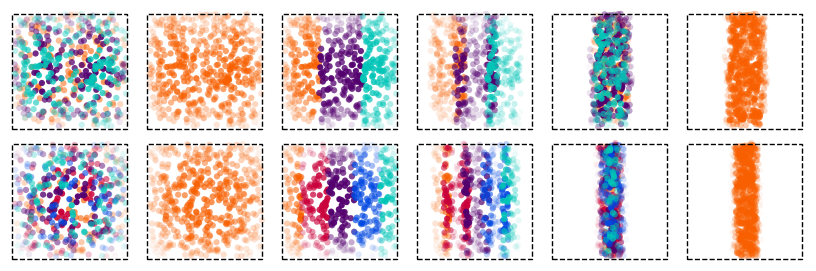

In [362]:
fig, axs = plt.subplots(2,6, figsize=(3.375*2*6/5, 2.6), sharex=True, constrained_layout=True)
coordx="z"
coordy="x"
scale_velocity=False
cmap = "cmr.guppy"
for Ci, C in enumerate([Cs[0], Cs[-1]]):
    for axi, ti in enumerate([0, 1, 2, 102, 105, -1]):
        plot_phasespace_color_mJ(C, axs[Ci, axi], ti=ti, coordx=coordx, coordy=coordy, 
                                scale_velocity=scale_velocity,
                                cmap=cmap,
                                s=20, 
                                Nsample=500)
        axs[Ci, axi].add_patch(plt.Rectangle([-0.26,-0.26], 0.51, 0.51, ec="k", ls="--", fc="none"))
        axs[Ci, axi].set_xlim(-0.27,0.27)
        axs[Ci, axi].set_ylim(-0.27,0.27)
        axs[Ci, axi].set_axis_off()
        axs[Ci, axi].set_aspect(1)
plt.savefig("figures/MOP_realspace_simple.png", dpi=600, bbox_inches="tight")

Plotting 2D contour slice of gradient...


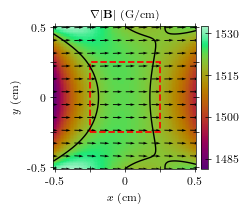

In [846]:
plot_domain = Domain(meshspec=[[-0.51, 0.51, 101]]*3)
#levels=[1515, 1521, 1522, 1523, 1524, 1530]
levels = list(np.arange(1490, 1535, 10))
levels=[1520]
fig, ax = mop_plot.plot_slice(
                    figsize=(2,2),
                    plane=("x", 0.0),
                    domain=plot_domain,
                    transpose=True,
                    unit="G_per_cm", 
                    image=True,
                    cmap=cmap,
                    contours=levels, 
                    label_contours=False,
                    #contour_label_positions=[(0, 0.2),(0,0.4),(0, -0.2),(0, -0.4)],
                    arrows=True,
                    skip_arrows=9)


ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, 
                       color="r", fill=None, alpha=1, lw=1.25, ls="--"))
ax.set_xticks([-0.5, -0.25, 0, 0.25,  0.5])
ax.set_xticklabels([-0.5, "", 0, "",  0.5])
ax.set_yticks([-0.5, -0.25, 0, 0.25,  0.5])
ax.set_yticklabels([-0.5, "", 0, "",  0.5])
ax.set_xlabel("$x$ (cm)")
ax.set_title(r"$\nabla |{\bf B}|$ (G/cm)")
ax.get_images()[-1].colorbar.set_ticks(list(np.arange(1485, 1535, 15)))
ax.get_images()[-1].colorbar.set_label("")

plt.savefig(f"figures/gradnorm_slice_simple.png", dpi=1000, bbox_inches="tight")


In [818]:
1528 - 1488

40

In [819]:
12*4

48

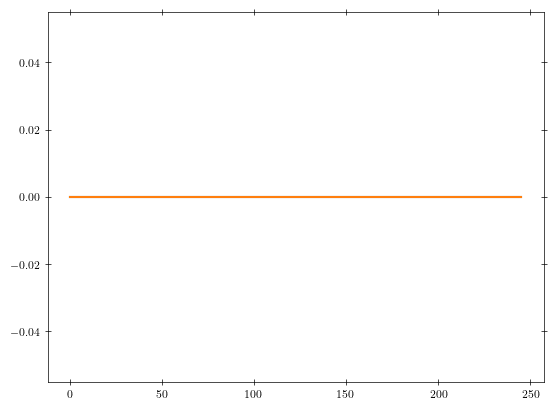

In [925]:
reload(magnetics)

from magnetics import current_pulse
for pulse in C.pulses:
    if pulse["field"] not in (None, "expand_tof"):
        plt.plot(current_pulse(C.ts, **pulse))

True

In [425]:
ratio_opts, t0_opts

(array([[[ 1.7306564 ],
         [ 5.03311047],
         [ 9.32734632],
         [12.64687144]]]),
 array([[[ 295.],
         [ 880.],
         [3610.],
         [2440.]]]))

-0.052274411578546474
-0.005961261136912007
-0.05209778748865335
-0.0971769991371516


Text(0, 0.5, 'Counts')

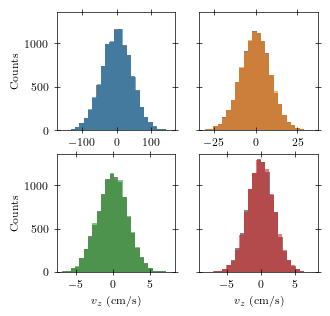

In [426]:
fig, axs = plt.subplots(2,2, figsize=(3.375, 3.375), sharey=True)
for Ci, C in enumerate(Cs):
    r, c = Ci//2, Ci%2
    color = f"C{Ci}"
    axs[r,c].hist(C.states[0, :, 5]*1e6, bins=25, color="grey", alpha=1)
    axs[r,c].hist(C.states[-1, :, 5]*1e6, bins=25, color=color, alpha=0.6)
    print(100 * (np.std(C.states[0, :, 5]) - np.std(C.states[-1, :, 5]))/np.std(C.states[0, :, 5]))
axs[1,0].set_xlabel("$v_z$ (cm/s)")
axs[1,1].set_xlabel("$v_z$ (cm/s)")
axs[0,0].set_ylabel("Counts")
axs[1,0].set_ylabel("Counts")

Text(0, 0.5, 'Counts')

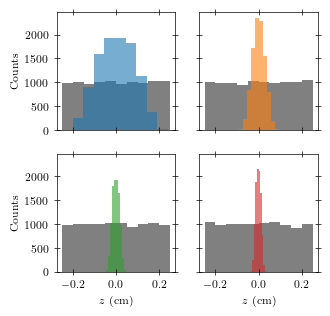

In [427]:
fig, axs = plt.subplots(2,2, figsize=(3.375, 3.375), sharey=True, sharex=True)


for Ci, C in enumerate(Cs):
    r, c = Ci//2, Ci%2
    color = f"C{Ci}"
    axs[r,c].hist(C.states[0, :, 2], bins=10, color="grey", alpha=1)
    axs[r,c].hist(C.states[-1, :,2], bins=10, color=color, alpha=0.6)
axs[1,0].set_xlabel("$z$ (cm)")
axs[1,1].set_xlabel("$z$ (cm)")
axs[0,0].set_ylabel("Counts")
axs[1,0].set_ylabel("Counts")

1.0
1.0
1.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
5574.646464646465
5574.646464646465
5575.646464646465
5576.646464646465
5577.646464646465
5578.646464646465
5579.646464646465
5580.646464646465
5581.646464646465
5582.646464646465
5583.646464646465
5584.646464646465


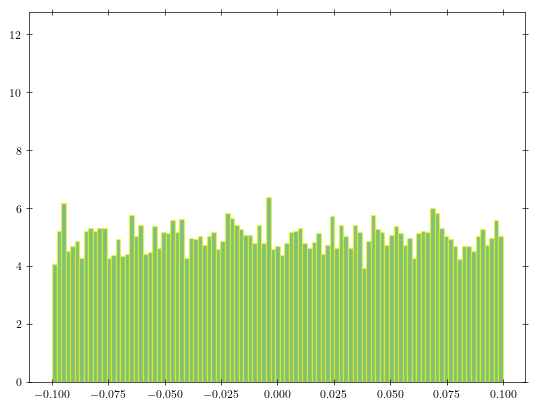

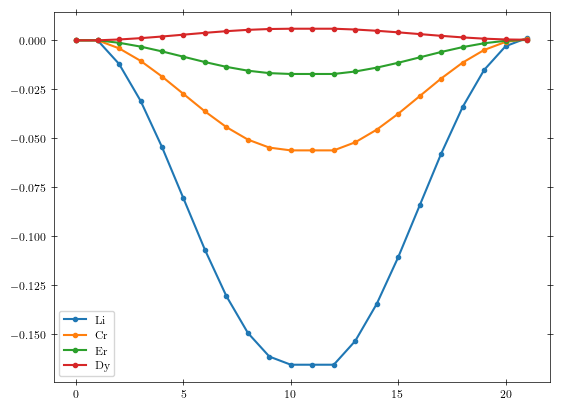

In [861]:
for atom, C in zip(atoms,Cs):
    plt.plot(np.mean(C.states, axis=1)[:,5]*1e6, marker=".", label=atom)
plt.legend()

In [862]:
 C.states.var(axis=1)[0,5], C.states.var(axis=1)[-1,5]

(1.5369257980910982e-25, 1.786920694262625e-18)

In [863]:
 C.states.mean(axis=1)[0,5], C.states.mean(axis=1)[-1,5]

(-1.8599932306471325e-15, 2.9924501925816966e-10)

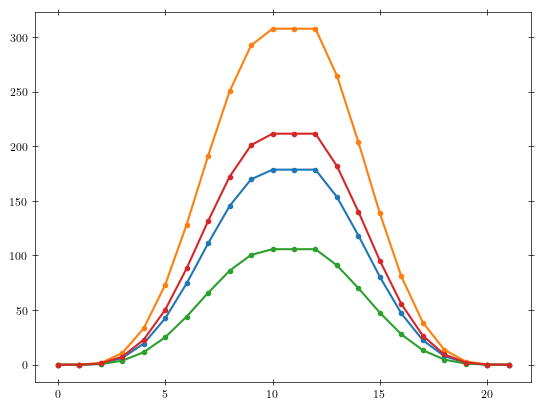

In [864]:
for atom, C in zip(atoms,Cs):
    T = Atoms[atom]["mass"] * C.states.var(axis=1)[:,5] / kB
    plt.plot(T*1e6, marker=".")

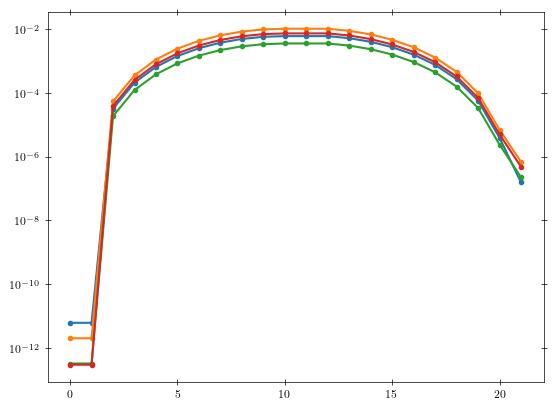

In [865]:
for atom, C in zip(atoms,Cs):
    T = Atoms[atom]["mass"] * C.states.var(axis=1)[:,4] / kB
    plt.semilogy(T*1e6, marker=".")